In [ ]:
# Dependencies
!pip install -U "huggingface_hub[cli]"
!pip install transformers
!pip install trl
!pip install torch
!pip install wandb
!pip install matplotlib
!pip install seaborn
!pip install accelerate

In [ ]:
# Imports
from google.colab import drive
import random
import json
import os
import torch
import glob
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer
from trl import RewardTrainer, RewardConfig
from trl.trainer.utils import SIMPLE_CHAT_TEMPLATE
from datasets import load_dataset, Dataset
from peft import LoraConfig, TaskType
from huggingface_hub import login

### Global Helper Functions

In [ ]:
def read_json_file(file_path):
  """Reads a JSON file and returns the data as a Python object.

  Args:
    file_path: The path to the JSON file.

  Returns:
    A Python object (usually a dictionary or a list) representing the JSON data.
  """
  with open(file_path, 'r') as file:
    data = json.load(file)
  return data

def read_txt_file(file_path):
    """Reads a txt file and returns its content.

    Args:
      file_path: Path to the txt file.

    Returns:
      The entire content of the file as a string.
    """
    with open(file_path, 'r') as file:
        file_content = file.read()
    return file_content

def get_all_files(folder_path):
  """Gets a list of all files in a folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    A list of strings, where each string is the name of a file in the folder.
  """
  files = []
  for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    if os.path.isfile(item_path):
      files.append(item)
  return files

def visualize_barplot(column, data, title, xlabel, ylabel):
  """Visualizes the distribution of a list of data.
  Args:
    data: A list of data to visualize.
    title: The title of the plot.
    xlabel: The label for the x-axis.
    ylabel: The label for the y-axis.
  """
  plt.figure(figsize=(10, 5))
  ax = sns.countplot(x=column, data=data)
  ax.bar_label(ax.containers[0])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

### GCP Virtual Machine Setup

Mle-bench leverages aideml in order to quantify benchmark performance against Kaggle competitions. In order to run aideml, mle-bench provides docker files that build the necessary images to run aideml. Below, you will find the code to install docker on GCP VM (Debian):

In [ ]:
# Installing Docker

# Add Docker's official GPG key
sudo apt-get update
sudo apt-get install ca-certificates curl
sudo install -m 0755 -d /etc/apt/keyrings
sudo curl -fsSL https://download.docker.com/linux/debian/gpg -o /etc/apt/keyrings/docker.asc
sudo chmod a+r /etc/apt/keyrings/docker.asc

# Add the repository to Apt sources
echo \
  "deb [arch=$(dpkg --print-architecture) signed-by=/etc/apt/keyrings/docker.asc] https://download.docker.com/linux/debian \
  $(. /etc/os-release && echo "$VERSION_CODENAME") stable" | \
  sudo tee /etc/apt/sources.list.d/docker.list > /dev/null
sudo apt-get update

# Install the latest version
sudo apt-get install docker-ce docker-ce-cli containerd.io docker-buildx-plugin docker-compose-plugin

Because mle-bench leverages Docker in order to run the AIDE agent, it is important to ensure proper security measures. Mle-bench requires the installation and usage of sysbox. Sysbox is a container runtime that isolates docker containers from the host system. This prevents malicious containers from potentially comprising the host. Below, you will find the code to install Sysbox on GCP VM (Debian):

In [ ]:
# Installing Sysbox

# Fetch latest version
wget https://downloads.nestybox.com/sysbox/releases/v0.6.5/sysbox-ce_0.6.5-0.linux_amd64.deb

# Stop all running docker containers
docker rm $(docker ps -a -q) -f

# Install latest version
sudo apt-get install jq
sudo apt-get install ./sysbox-ce_0.6.5-0.linux_amd64.deb

In order to ensure a proper python environment with python=3.11 and manage dependencies correctly, we opted to use miniconda for package management and virtual python environments. Below, you will find the code to install miniconda and create a virtual environment:

In [ ]:
# Fetch linux distribution of miniconda
curl -O https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
# Install miniconda
bash ~/Miniconda3-latest-Linux-x86_64.sh
# Create virtual environment to use for the project
conda create --name aiderl python=3.11

Below, you will find the code to clone the mle-bench repository and build the mle-bench module:

In [ ]:
# Clone the mle-bench repository
git clone https://github.com/openai/mle-bench.git /home/mle-bench

cd /home/mle-bench
# Fetch mle-bench competition data that is stored using Git LFS
git lfs fetch --all
git lfs pull
# Install mlebench modules with pip
pip install -e .

Below, you will find the code to create the data directory, which will store the kaggle competition data

In [ ]:
mkdir /home/data

### Kaggle - Competition Data Download & Preparation

Mle-bench provides python scripts and a python cli to download kaggle competition data via the Kaggle API. The CLI command used specifies a competition id for the competition to download, an output directory, and to skip the generation of checksums to speed up the process of downloading data. Mle-bench also provides python preparation skips for each competition. Since Kaggle does not provide the held-out test set for each competition, the preparation scriptssplit the publicly available training set into a new training and test set. Below, find the CLI commands to download and prepare each of the 5 competitions used in our project:

In [ ]:
cd /home/mle-bench/mlebench

mlebench prepare -c spooky-author-identification --data-dir /home/data --skip-verification
mlebench prepare -c nomad2018-predict-transparent-conductors --data-dir /home/data --skip-verification
mlebench prepare -c google-quest-challenge --data-dir /home/data --skip-verification
mlebench prepare -c random-acts-of-pizza --data-dir /home/data --skip-verification
mlebench prepare -c text-normalization-challenge-english-language --data-dir /home/data --skip-verification

### Building Docker Images

Mle-bench provides a base Docker image mlebench-env which is the base environment used by the AIDE agent. This base image contains:



*   Conda environment used to execute our agents. We optionally (default true) install Python packages in this environment which are commonly used across our agents.
*   Instructions for agents to follow when creating their submission
*  Grading server for agents to use when checking that the structure of their submission is correct

Below, you will find the code to build the base docker image:






In [ ]:
cd /home/mle-bench

docker build --platform=linux/amd64 -t mlebench-env -f environment/Dockerfile .

Mle-bench provides a python script to be able to run the AIDE agent. However, this script leverages docker to run the agent within a container. Below, you will find the code to build the docker image for the AIDE agent:

In [ ]:
cd /home/mle-bench

export SUBMISSION_DIR=/home/submission
export LOGS_DIR=/home/logs
export CODE_DIR=/home/code
export AGENT_DIR=/home/agent

docker build --platform=linux/amd64 -t <agent> agents/<agent>/
  --build-arg SUBMISSION_DIR=$SUBMISSION_DIR
  --build-arg LOGS_DIR=$LOGS_DIR
  --build-arg CODE_DIR=$CODE_DIR
  --build-arg AGENT_DIR=$AGENT_DIR

### Teacher Model - AIDE agent with GPT-4o

As part of the image build for the AIDE agent, a config.yaml file is specified which contains the relevant information for the agent, such as the number of steps, the code model, the feedback model, the number of debug steps, debug probability, etc... These crucial parameters are what guide how the AIDE agent runs. Below, you will find the configurations used by the AIDE agent for GPT-4o:

In [ ]:
vars:
  step_count: &step_count 20
  time_limit: &time_limit 86400 # 24 hrs

defaults: &defaults
  start: aide/start.sh
  dockerfile: aide/Dockerfile
  kwargs_type: omegaconf
  env_vars: &env_vars
    TIME_LIMIT_SECS: *time_limit
    STEP_LIMIT: *step_count

kwargs_common: &kwargs_common
  agent.search.max_debug_depth: 20 # debug down a branch for up to 20 steps
  agent.search.debug_prob: 1 # always debug when there's something to debug
  agent.time_limit: *time_limit
  exec.timeout: 32400 # 9 hours limit _per step_, to match max of kaggle.com
  copy_data: False # use symbolic links

aide:
  <<: *defaults
  kwargs:
    <<: *kwargs_common
    agent.code.model: gpt-4o-2024-08-06
    agent.feedback.model: gpt-4o-2024-08-06
    agent.steps: *step_count
  env_vars:
    <<: *env_vars
    OPENAI_API_KEY: ${{ secrets.OPENAI_API_KEY }}

Leveraging the AIDE framework, mle-bench generates solutions to the Kaggle competitions using a LLM that is configurable. As part of our project, we opted for a teacher-student approach. In order to generate the data that would be used for RL with the student model, we first had to run the AIDE agent for the 5 competitions using GPT-4o via OpenAI API. The parameters of the script include the id of the agent, a text file containing the competition names to run the agent with, as well as the directory containing the Kaggle competition data. Below, you will find the code to launch the AIDE agent using GPT-4o.

In [ ]:
python run_agent.py --agent-id aide --competition-set /home/competitions.txt --data-dir /home/data

### Teacher Model - GPT-4o Journals

After running the AIDE agent using GPT-4o and OpenAI for each of the five competitions, five journal.json files were produced, one for each competition. The journal.json is a JSON file containing the metadata of the experiment runs, including all the code generated in intermediate steps, plan, evaluation results, etc. These will be the basis of our data using for reinforcement learning with the student model. Below, you will find a snippet of a journal.json:

In [ ]:
{
  "nodes": [
    {
      "code": "import pandas as pd\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import cross_val_score, StratifiedKFold\nfrom sklearn.preprocessing import LabelEncoder\nimport numpy as np\n\n# Load the data\ntrain = pd.read_csv(\"./input/train.csv\")\ntest = pd.read_csv(\"./input/test.csv\")\n\n# Encode labels\nlabel_encoder = LabelEncoder()\ny = label_encoder.fit_transform(train[\"author\"])\n\n# Text preprocessing and feature extraction\ntfidf = TfidfVectorizer(max_features=10000, stop_words=\"english\")\nX_train = tfidf.fit_transform(train[\"text\"])\nX_test = tfidf.transform(test[\"text\"])\n\n# Model training and evaluation\nmodel = LogisticRegression(max_iter=1000)\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\ncv_scores = cross_val_score(model, X_train, y, cv=cv, scoring=\"neg_log_loss\")\nprint(f\"Cross-validated log loss: {-np.mean(cv_scores):.4f}\")\n\n# Train the model on the full training data\nmodel.fit(X_train, y)\n\n# Make predictions on the test set\npredictions = model.predict_proba(X_test)\n\n# Prepare the submission file\nsubmission = pd.DataFrame(predictions, columns=label_encoder.classes_)\nsubmission.insert(0, \"id\", test[\"id\"])\nsubmission.to_csv(\"./submission/submission.csv\", index=False)\n",
      "plan": "To solve the problem of author identification, we'll use a simple text classification approach. We'll start by preprocessing the text data using TF-IDF vectorization to convert the sentences into numerical features. Then, we'll train a logistic regression model on the training data, as it is a good baseline for text classification tasks. We'll evaluate the model using 5-fold cross-validation to ensure robustness. Finally, we'll predict the probabilities for each author on the test set and save the results in the required submission format.",
      "step": 0,
      "id": "3c36d69742dc488db2941e195285edb5",
      "ctime": 1733409507.01274,
      "parent": null,
      "children": [],
      "_term_out": "<OMITTED>",
      "exec_time": 30.964609146118164,
      "exc_type": null,
      "exc_info": null,
      "exc_stack": "<OMITTED>",
      "analysis": "The code successfully trains a logistic regression model to predict the author of text excerpts. The cross-validated log loss on the training data is 0.5932, indicating a reasonable performance. The predictions are saved in a 'submission.csv' file in the correct directory.",
      "metric": {
        "value": 0.5932,
        "maximize": false
      },
      "is_buggy": false
    },
    {
      "code": "import pandas as pd\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.preprocessing import LabelEncoder\nimport numpy as np\n\n# Load data\ntrain = pd.read_csv(\"./input/train.csv\")\ntest = pd.read_csv(\"./input/test.csv\")\n\n# Prepare the data\nX_train = train[\"text\"]\ny_train = train[\"author\"]\nX_test = test[\"text\"]\n\n# Encode the target labels\nlabel_encoder = LabelEncoder()\ny_train_encoded = label_encoder.fit_transform(y_train)\n\n# Vectorize the text data using TF-IDF\ntfidf_vectorizer = TfidfVectorizer(max_features=15000)\nX_train_tfidf = tfidf_vectorizer.fit_transform(X_train)\nX_test_tfidf = tfidf_vectorizer.transform(X_test)\n\n# Train the Random Forest Classifier\nrf_clf = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Evaluate using cross-validation\ncv_scores = cross_val_score(\n    rf_clf, X_train_tfidf, y_train_encoded, cv=5, scoring=\"neg_log_loss\"\n)\nprint(f\"Cross-validated log loss: {-np.mean(cv_scores)}\")\n\n# Fit the model on the full training data\nrf_clf.fit(X_train_tfidf, y_train_encoded)\n\n# Predict probabilities for the test set\ntest_probs = rf_clf.predict_proba(X_test_tfidf)\n\n# Prepare the submission file\nsubmission = pd.DataFrame(test_probs, columns=label_encoder.classes_)\nsubmission.insert(0, \"id\", test[\"id\"])\nsubmission.to_csv(\"./submission/submission.csv\", index=False)\n",
      "plan": "To improve the current solution, we can try using a more sophisticated machine learning model that is well-suited for text classification tasks. One such model is the Random Forest Classifier, which is an ensemble learning method that can capture complex patterns in the data. We will replace the logistic regression model with a Random Forest Classifier and evaluate its performance using 5-fold cross-validation. Additionally, we will adjust the `max_features` parameter in the TF-IDF vectorizer to see if it affects the performance. After evaluating the model, we will save the predictions for the test set in the required submission format.",
      "step": 8,
      "id": "f9dc3409127842cebd7671d60a3e56ca",
      "ctime": 1733409719.2079215,
      "parent": null,
      "children": [],
      "_term_out": [
        "Cross-validated log loss: 0.7903368920707906",
        "\n",
        "Execution time: 2 minutes seconds (time limit is 9 hours)."
      ],
      "exec_time": 161.0707070827484,
      "exc_type": null,
      "exc_info": null,
      "exc_stack": null,
      "analysis": "The code executed successfully, producing a submission file in the required format. The cross-validated log loss achieved during training was 0.7903, indicating the model's performance on the validation data. The objective is to minimize this log loss value as it is a measure of error.",
      "metric": {
        "value": 0.7903368920707906,
        "maximize": false
      },
      "is_buggy": false
    },
    ...
  ]
}

#### Spooky Author Identification Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/gpt/spooky-author-identification/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nfrom sklearn.feature_extr...,"To solve the problem of author identification,...",0,3c36d69742dc488db2941e195285edb5,1.733410e+09,None,[],<OMITTED>,30.964609,None,None,<OMITTED>,The code successfully trains a logistic regres...,"{'value': 0.5932, 'maximize': False}",False
1,import pandas as pd\nfrom sklearn.feature_extr...,"To solve the problem of author identification,...",1,2b978bafdbbe4d43a3a47035d8111799,1.733410e+09,None,[],"[Cross-validated Log Loss:, , 0.6421510418819...",12.797344,None,None,None,The code successfully trains a logistic regres...,"{'value': 0.6421510418819892, 'maximize': False}",False
2,import pandas as pd\nfrom sklearn.feature_extr...,"To solve the problem of author identification,...",2,6cfaa66890214bbcacfadae47872440d,1.733410e+09,None,[],"[Traceback (most recent call last):\n File ""r...",1.213070,ValueError,{'args': [' All the 5 fits failed. It is very ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a ValueError. The ...,"{'value': None, 'maximize': None}",True
3,import pandas as pd\nfrom sklearn.feature_extr...,"To solve the author identification problem, we...",3,ae8ef5510c3745959c0c2497d9ab2b40,1.733410e+09,None,[],<OMITTED>,31.658552,None,None,<OMITTED>,"The code successfully loads the data, preproce...","{'value': 0.5425264934217372, 'maximize': False}",False
4,import pandas as pd\nfrom sklearn.feature_extr...,"To solve the author identification problem, we...",4,32a709e410c44ed49d56672d116422cf,1.733410e+09,None,[],[5-fold Cross-validated Log Loss: 0.6023623498...,1.002993,None,None,None,The script successfully trains a Multinomial N...,"{'value': 0.6023623498372278, 'maximize': False}",False


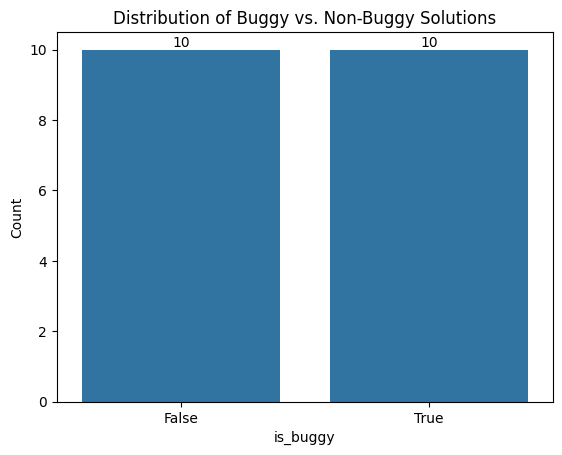

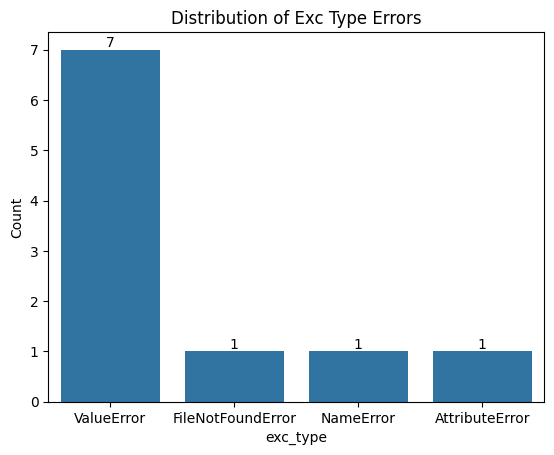

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Nomad2018 Predict Transparent Conductors Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/gpt/nomad2018-predict-transparent-conductors/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nimport numpy as np\nfrom ...,"To solve this problem, we'll use a simple Rand...",0,1c0d3e432f064456b6096378baf6d19c,1.733494e+09,None,[],<OMITTED>,3.148229,None,None,<OMITTED>,The code successfully trained a RandomForestRe...,"{'value': 0.06674020785450144, 'maximize': False}",False
1,import pandas as pd\nfrom sklearn.model_select...,"To solve this problem, we will use a Gradient ...",1,57899a907b8d47c59ebd68aab15928c9,1.733494e+09,None,[],<OMITTED>,2.061714,None,None,<OMITTED>,The code successfully trains two Gradient Boos...,"{'value': 0.06186862929858482, 'maximize': False}",False
2,import pandas as pd\nfrom sklearn.model_select...,"To solve this problem, we will use a simple Li...",2,e8abe1c1445c4a8a8a6aa01611f0ea44,1.733494e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.560699,ValueError,{'args': ['Mean Squared Logarithmic Error cann...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution of the script failed due to a Va...,"{'value': None, 'maximize': None}",True
3,import pandas as pd\nimport numpy as np\nfrom ...,"To solve this problem, we will use a simple Li...",3,417019a7b15144d9bc505fc690b47ee1,1.733494e+09,None,[],[Cross-validated RMSLE for formation energy: 0...,0.599034,None,None,None,The code successfully trains a linear regressi...,"{'value': 0.1229, 'maximize': False}",False
4,import pandas as pd\nfrom sklearn.model_select...,"To solve this problem, we will use a Decision ...",4,5f13f99310a3403f933fae2197480d45,1.733494e+09,None,[],"[Mean RMSLE: 0.09154950493950668, \n, Executio...",0.680371,None,None,None,The code successfully trains a Decision Tree R...,"{'value': 0.09154950493950668, 'maximize': False}",False


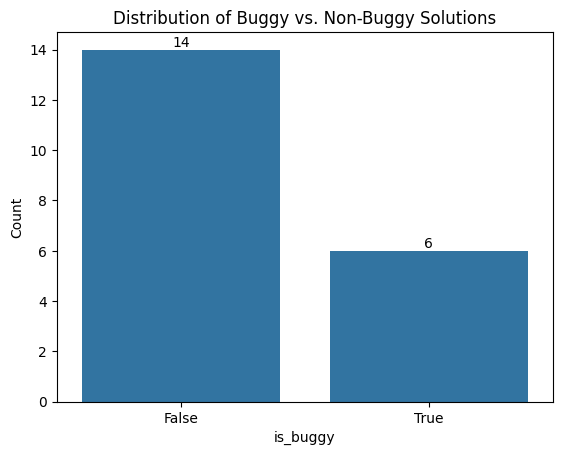

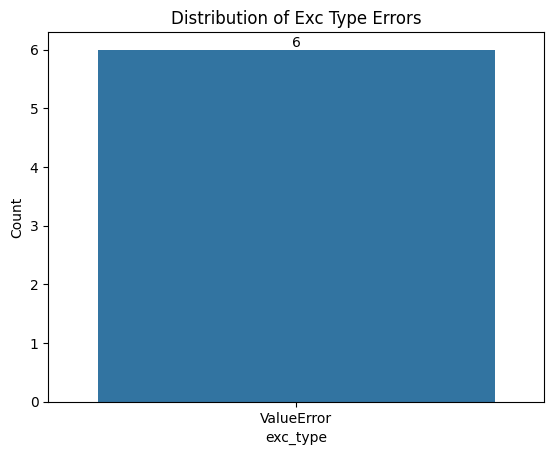

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Google Quest Challenge Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/gpt/google-quest-challenge/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nfrom sklearn.feature_extr...,"To tackle this problem, we will use a simple m...",0,97b71441d46f4361aa270fb3cc0f5348,1.733504e+09,None,[],<OMITTED>,12.617502,None,None,<OMITTED>,"The code execution resulted in a bug, as indic...","{'value': None, 'maximize': None}",True
1,import pandas as pd\nfrom sklearn.feature_extr...,To tackle the problem of predicting subjective...,1,e406146bea794c59958f15c61faae573,1.733504e+09,None,[],<OMITTED>,17.240064,None,None,<OMITTED>,The execution of the training script was succe...,"{'value': 0.2653, 'maximize': True}",False
2,import pandas as pd\nimport numpy as np\nfrom ...,To address the problem of predicting subjectiv...,2,5390225fa32949928a41ec0d18a50020,1.733504e+09,None,[],[question_asker_intent_understanding: CV Spear...,12.344790,None,None,None,The code successfully trains a Ridge regressio...,"{'value': 0.2597, 'maximize': True}",False
3,import pandas as pd\nfrom sklearn.feature_extr...,To tackle the problem of predicting subjective...,3,d223ffaf4a36431e8248d6d124327fe0,1.733504e+09,None,[],<OMITTED>,14.177042,None,None,<OMITTED>,"The code executed successfully, training a Rid...","{'value': 0.27940400197330073, 'maximize': True}",False
4,import pandas as pd\nfrom sklearn.feature_extr...,To tackle the problem of predicting subjective...,4,186a3111dbed4f39ab3aee7e1fb5aab1,1.733504e+09,None,[],[Mean Spearman Correlation: -0.048467493489186...,17.107347,None,None,None,"The code executes successfully, producing a su...","{'value': -0.048467493489186365, 'maximize': T...",False


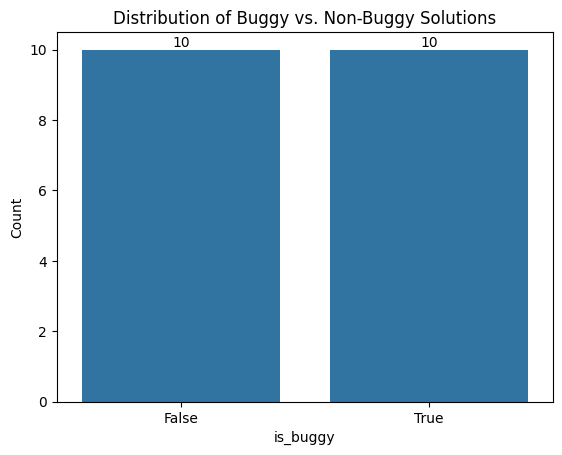

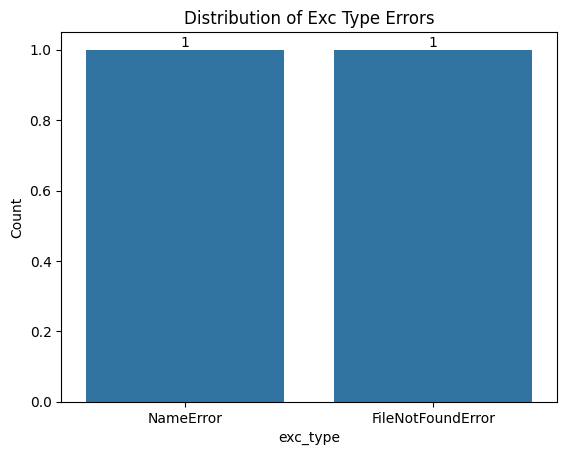

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Random Acts of Pizza Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/gpt/random-acts-of-pizza/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nimport numpy as np\nfrom ...,"To solve this task, we'll use a simple machine...",0,ccba4666843148018fd49e2aa898ce96,1.733509e+09,None,[],<OMITTED>,29.494561,None,None,<OMITTED>,"The execution of the script was successful, an...","{'value': 0.5544519632279448, 'maximize': True}",False
1,import json\nimport pandas as pd\nfrom sklearn...,"To solve this task, we'll use a Random Forest ...",1,b67c6dfda4f540abb0ba48942d34fd8e,1.733509e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.729070,ValueError,"{'args': ['blocks[0,:] has incompatible row di...",[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a ValueError cause...,"{'value': None, 'maximize': None}",True
2,import pandas as pd\nimport numpy as np\nimpor...,"To solve the task, we will use a Random Forest...",2,b6ba84688cff449681711c6bf671ec6b,1.733509e+09,None,[],<OMITTED>,10.509963,None,None,<OMITTED>,"The code executed successfully, producing a su...","{'value': 0.6265931357155375, 'maximize': True}",False
3,import json\nimport pandas as pd\nimport numpy...,"To solve the task, we will use a Gradient Boos...",3,b8fc9d1ff6a44d04ad59bb37e658a962,1.733509e+09,None,[],<OMITTED>,0.871391,KeyError,{'args': ['['request_text'] not found in axis']},<OMITTED>,The execution of the code failed due to a KeyE...,"{'value': None, 'maximize': None}",True
4,import json\nimport pandas as pd\nimport numpy...,"To solve this task, we will use a Gradient Boo...",4,8d9ed946a8564568a1b0e38b95e57b04,1.733509e+09,None,[],"[Validation AUC: 0.6156049198416305, \n, Cross...",26.129523,None,None,None,The model was successfully trained and evaluat...,"{'value': 0.6156049198416305, 'maximize': True}",False


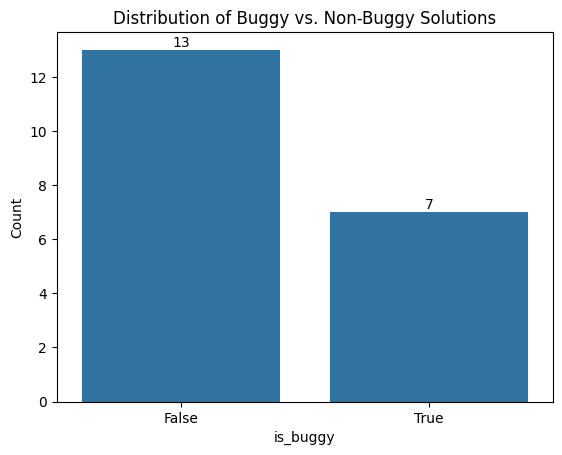

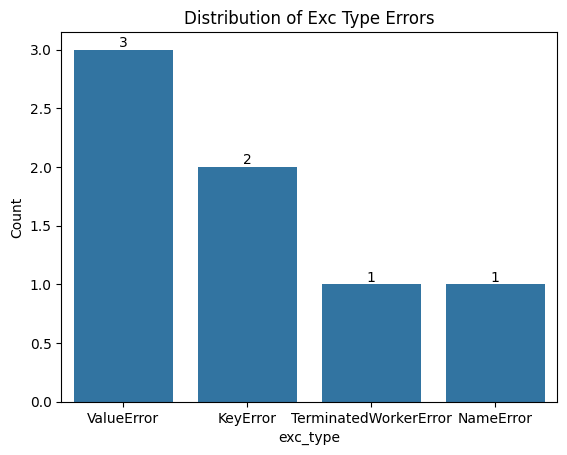

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Text Normalization Challenge English Language Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/gpt/text-normalization-challenge-english-language/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nfrom sklearn.model_select...,"To solve the text normalization task, I will s...",0,4e2ca7556fe4415ab191e2ff3ef482c1,1.733525e+09,None,[],<OMITTED>,0.000000,RuntimeError,{},<OMITTED>,"The execution of the code failed, as indicated...","{'value': None, 'maximize': None}",True
1,import pandas as pd\nfrom sklearn.model_select...,"To tackle this text normalization task, I will...",1,124bed3469c04e2c80cb2ab13cac4c8d,1.733525e+09,None,[],<OMITTED>,3600.328713,TimeoutError,{'args': []},<OMITTED>,The code execution failed due to a timeout err...,"{'value': None, 'maximize': None}",True
2,import pandas as pd\nfrom sklearn.model_select...,"To solve the text normalization task, I will u...",2,3057779fa18d4552a96309d294dc5a2b,1.733529e+09,None,[],"[Traceback (most recent call last):\n File ""r...",141.732567,ValueError,{'args': [' All the 5 fits failed. It is very ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to an error in the cr...,"{'value': None, 'maximize': None}",True
3,import pandas as pd\nfrom sklearn.model_select...,"To tackle the text normalization problem, we w...",3,d5360bdd4103425a81f8c5f23850f651,1.733529e+09,None,[],"[Traceback (most recent call last):\n File ""r...",79.374603,ValueError,{'args': [' All the 5 fits failed. It is very ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a ValueError cause...,"{'value': None, 'maximize': None}",True
4,import pandas as pd\nfrom sklearn.model_select...,"To solve the text normalization task, we will ...",4,70d0d4b90b1b4317a6b06a8e65b7ac7e,1.733529e+09,None,[],"[Traceback (most recent call last):\n File ""r...",10.840529,TypeError,{'args': ['object of type 'float' has no len()']},[[/opt/conda/envs/agent/lib/python3.11/site-pa...,"The execution failed due to a TypeError, indic...","{'value': None, 'maximize': None}",True


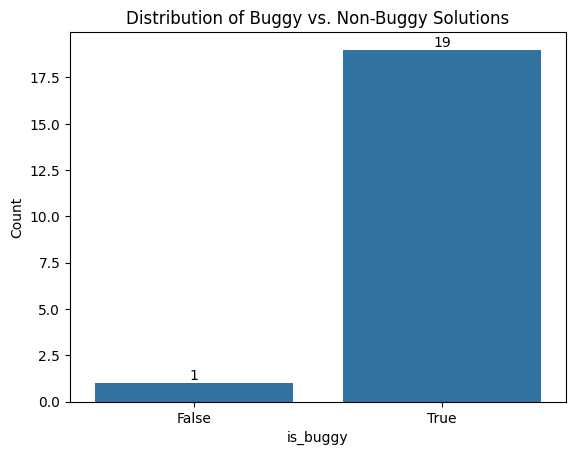

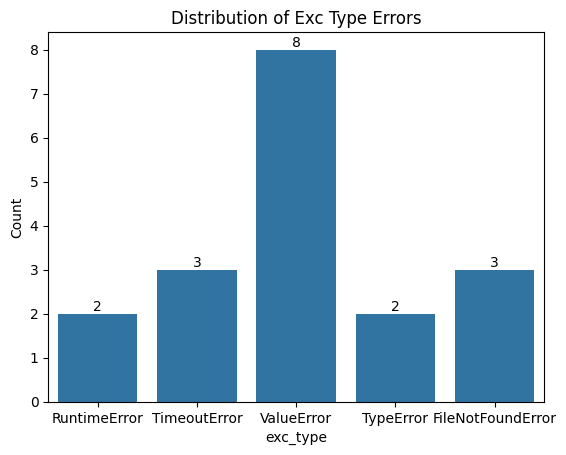

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

### Student Model - AIDE agent with Llama3.2 1B

As part of the image build for the AIDE agent, a config.yaml file is specified which contains the relevant information for the agent, such as the number of steps, the code model, the feedback model, the number of debug steps, debug probability, etc... These crucial parameters are what guide how the AIDE agent runs. Below, you will find the configurations used by the AIDE agent for Llama3.2 1B:

In [ ]:
vars:
  step_count: &step_count 20
  time_limit: &time_limit 86400 # 24 hrs

defaults: &defaults
  start: aide/start.sh
  dockerfile: aide/Dockerfile
  kwargs_type: omegaconf
  env_vars: &env_vars
    TIME_LIMIT_SECS: *time_limit
    STEP_LIMIT: *step_count

kwargs_common: &kwargs_common
  agent.search.max_debug_depth: 20 # debug down a branch for up to 20 steps
  agent.search.debug_prob: 1 # always debug when there's something to debug
  agent.time_limit: *time_limit
  exec.timeout: 32400 # 9 hours limit _per step_, to match max of kaggle.com
  copy_data: False # use symbolic links

llama:
  <<: *defaults
  kwargs:
    <<: *kwargs_common
    agent.code.model: meta-llama/Llama-3.2-1B
    agent.feedback.model: gpt-4o-2024-08-06
    agent.steps: *step_count
  env_vars:
    <<: *env_vars
    OPENAI_API_KEY: ${{ secrets.OPENAI_API_KEY }}
    OPENROUTER_API_KEY: ${{ secrets.OPENROUTER_API_KEY }}

Leveraging the AIDE framework, mle-bench generates solutions to the Kaggle competitions using a LLM that is configurable. As part of our project, we opted for a teacher-student approach. In order to generate the data that would be used for RL with the student model, we first had to run the AIDE agent for the 5 competitions using Llama3.2 1B via OpenAI API and OpenRouter API. The parameters of the script include the id of the agent, a text file containing the competition names to run the agent with, as well as the directory containing the Kaggle competition data. Below, you will find the code to launch the AIDE agent using Llama3.2 1B.

In [ ]:
python run_agent.py --agent-id llama --competition-set /home/competitions.txt --data-dir /home/data

### Student Model - Llama3.2 1B Journals

After running the AIDE agent using Llama3.2 1B for each of the five competitions, five journal.json files were produced, one for each competition. The journal.json is a JSON file containing the metadata of the experiment runs, including all the code generated in intermediate steps, plan, evaluation results, etc. These will be the basis of our data using for reinforcement learning with the student model. Below, you will find a snippet of a journal.json:

In [ ]:
{
  "nodes": [
    {
      "code": "import pandas as pd\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.utils.class_weight import compute_class_weight\nimport numpy as np\n\n# Load the data\ntrain_df = pd.read_csv(\"./input/train.csv\")\ntest_df = pd.read_csv(\"./input/test.csv\")\n\n# Split the data into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(\n    train_df[\"text\"], train_df[\"author\"], test_size=0.2, random_state=42\n)\n\n# Create a CountVectorizer to convert text to numerical representation\nvectorizer = CountVectorizer(stop_words=\"english\")\n\n# Fit the vectorizer to the training data and transform both the training and validation data\nX_train_count = vectorizer.fit_transform(X_train)\nX_val_count = vectorizer.transform(X_val)\n\n# Compute the class weights\nclass_weights = compute_class_weight(\"balanced\", np.unique(y_train), y_train)\n\n# Train a Logistic Regression classifier with class weights\nclf = LogisticRegression(class_weight=\"balanced\")\nclf.fit(X_train_count, y_train)\n\n# Evaluate the model on the validation set\ny_pred_val = clf.predict(X_val_count)\nprint(\"Validation accuracy:\", accuracy_score(y_val, y_pred_val))\n\n# Make predictions on the test set\ntest_count = vectorizer.transform(test_df[\"text\"])\ny_pred_test = clf.predict(test_count)\n\n# Save the predictions to a submission file\nsubmission_df = pd.DataFrame(\n    {\n        \"id\": test_df[\"id\"],\n        \"EAP\": y_pred_test == \"EAP\",\n        \"HPL\": y_pred_test == \"HPL\",\n        \"MWS\": y_pred_test == \"MWS\",\n    }\n)\nsubmission_df.to_csv(\"./submission/submission.csv\", index=False)\n",
      "plan": "Based on the problem description, I will design a solution that uses a simple and efficient approach to classify the text into one of the three authors: EAP, HPL, or MWS.\n\n## Solution Sketch\n\nTo solve this problem, I will use a simple text classification approach based on the bag-of-words representation of the text. The idea is to train a classifier to predict the author of each sentence based on the word frequencies in the sentence. I will use the `CountVectorizer` from scikit-learn to convert the text into a numerical representation, and then train a classifier using the `LogisticRegression` algorithm.\n\n## Implementation",
      "step": 0,
      "id": "dc51d0b9da7049a891c0126fb3dbc180",
      "ctime": 1733806356.5610168,
      "parent": null,
      "children": [],
      "_term_out": "<OMITTED>",
      "exec_time": 1.1653785705566406,
      "exc_type": "TypeError",
      "exc_info": {
        "args": [
          "compute_class_weight() takes 1 positional argument but 3 were given"
        ]
      },
      "exc_stack": "<OMITTED>",
      "analysis": "The execution failed due to a TypeError in the compute_class_weight function call. The error message indicates that too many positional arguments were provided to the function. As a result, the script did not successfully produce a submission.csv file.",
      "metric": {
        "value": null,
        "maximize": null
      },
      "is_buggy": true
    },
    ...
  ]
}

#### Spooky Author Identification Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/llama3.2/spooky-author-identification/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nfrom sklearn.feature_extr...,"Based on the problem description, I will desig...",0,dc51d0b9da7049a891c0126fb3dbc180,1.733806e+09,None,[],<OMITTED>,1.165379,TypeError,{'args': ['compute_class_weight() takes 1 posi...,<OMITTED>,The execution failed due to a TypeError in the...,"{'value': None, 'maximize': None}",True
1,import pandas as pd\nfrom sklearn.model_select...,# Solution\n\n**Evaluation Metric:** We will u...,1,3badbb0a4c8e49bfa3bbbf0b3f40b8de,1.733806e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.569985,ValueError,{'args': ['could not convert string to float: ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a ValueError when ...,"{'value': None, 'maximize': None}",True
2,import pandas as pd\nfrom sklearn.feature_extr...,"## Solution Sketch\nTo solve this task, I prop...",2,c79b73c5a2034bc9a8e8f5ef802fc000,1.733806e+09,None,[],<OMITTED>,153.219014,ValueError,{'args': ['could not convert string to float: ...,<OMITTED>,The execution failed due to a bug in the code....,"{'value': None, 'maximize': None}",True
3,import torch\nimport torch.nn as nn\nimport to...,Here is a proposed solution:\n\nTo solve this ...,3,3202bd1e61ac425c8fcc949d765bcf57,1.733807e+09,None,[],[Execution time: a second seconds (time limit ...,1.447670,None,None,None,"The code contains several issues. Firstly, it ...","{'value': None, 'maximize': None}",True
4,import pandas as pd\nfrom sklearn.model_select...,"Based on the problem description, I will propo...",4,bb78769593614ebe9b303a596e6be18a,1.733807e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.604403,ValueError,{'args': ['could not convert string to float: ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution of the code failed due to a Valu...,"{'value': None, 'maximize': None}",True


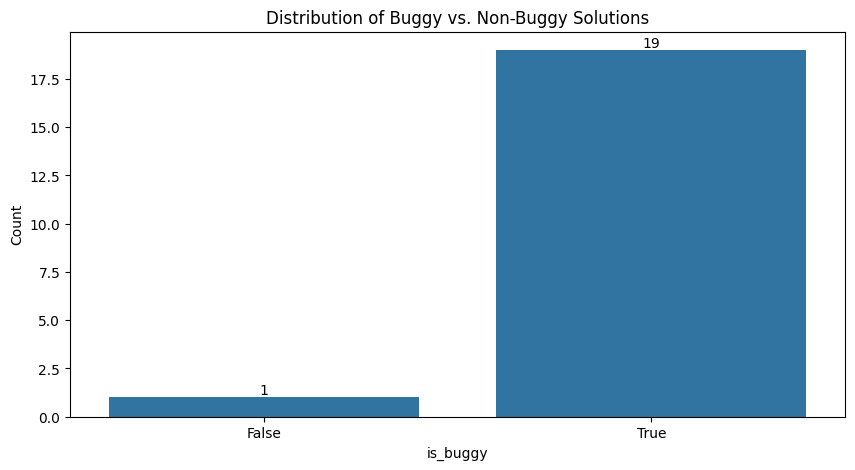

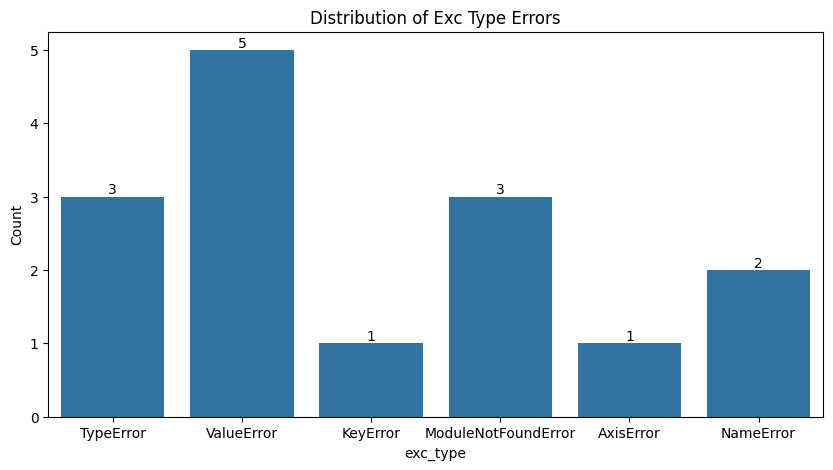

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Nomad2018 Predict Transparent Conductors Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/llama3.2/nomad2018-predict-transparent-conductors/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import torch\nimport torch.nn as nn\nimport to...,I will implement a solution using PyTorch and ...,0,b2e8c607199945f893e245d2ac7f447a,1.733807e+09,None,[],<OMITTED>,4.031259,ValueError,{'args': ['too many values to unpack (expected...,<OMITTED>,The execution failed due to a ValueError cause...,"{'value': None, 'maximize': None}",True
1,import pandas as pd\nimport numpy as np\nimpor...,I'm excited to start working on this problem. ...,1,3d8d2d1a54764a42a7ac7fbd95b7b47d,1.733807e+09,None,[],[Execution time: 2 seconds seconds (time limit...,2.112232,None,None,None,The execution log indicates that there is a bu...,"{'value': None, 'maximize': None}",True
2,# Import necessary libraries\nimport pandas as...,I'll provide a solution to the MLE-bench compe...,2,db8a87e956104ea79cc91ca023947bfb,1.733807e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.541340,KeyError,"{'args': ['['formation_energy_ev_natom', 'band...",[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a KeyError when tr...,"{'value': None, 'maximize': None}",True
3,import pandas as pd\nimport numpy as np\nfrom ...,"Given the complexity of the task, I will provi...",3,7ae65c9ae7314cf1a23078ea60158338,1.733807e+09,None,[],<OMITTED>,0.558079,ModuleNotFoundError,"{'args': ['No module named 'ase''], 'name': 'a...",<OMITTED>,The execution of the code failed due to a miss...,"{'value': None, 'maximize': None}",True
4,import numpy as np\nimport torch\nimport torch...,I'm excited to take on the challenge of solvin...,4,6b047dbc87e940b88e7a40d6320c986b,1.733807e+09,None,[],[ValueError: could not convert string to float...,2.354926,ValueError,"{'args': ['could not convert string 'id,spaceg...",[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a ValueError cause...,"{'value': None, 'maximize': None}",True


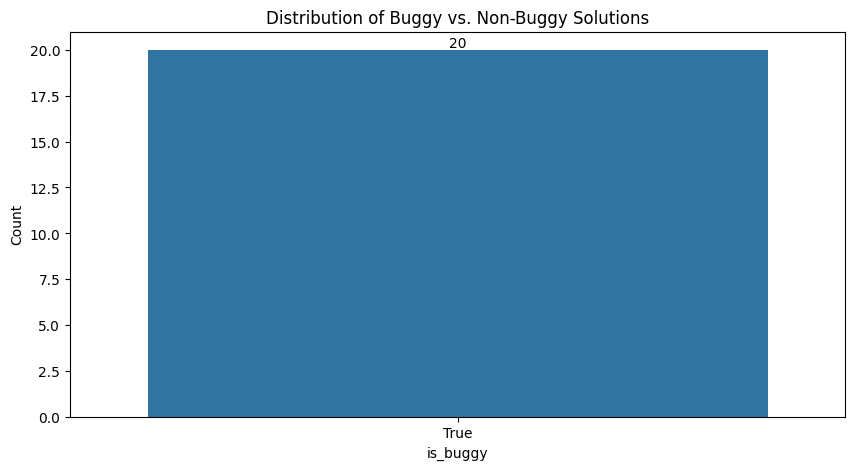

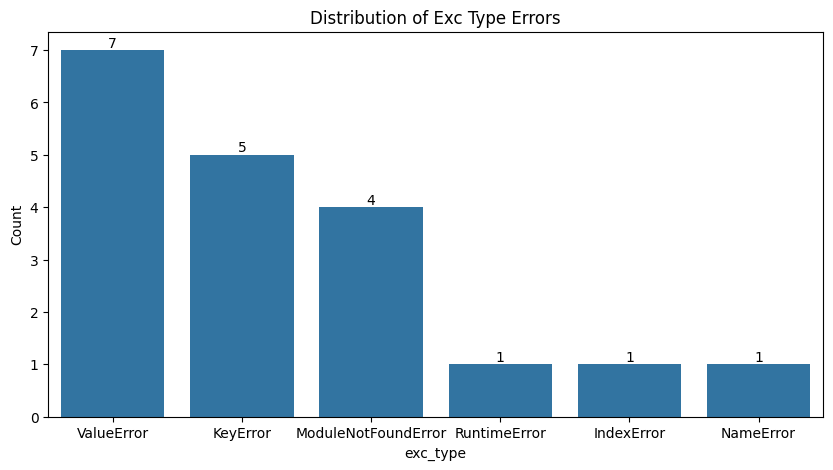

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Google Quest Challenge Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/llama3.2/google-quest-challenge/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nimport torch\nimport torc...,"Based on the problem description, here is a pr...",0,7730034b429648cfa5e1ffdf5e0e1888,1.733807e+09,None,[],<OMITTED>,3.978879,ValueError,{'args': ['Input 0 Which parts of fresh ...,<OMITTED>,The execution failed due to a ValueError. The ...,"{'value': None, 'maximize': None}",True
1,import pandas as pd\nimport torch\nfrom transf...,I'm excited to start working on this problem. ...,1,d97e625670a4482d9637cd34183fa76e,1.733807e+09,None,[],<OMITTED>,17.245304,ValueError,"{'args': ['Unable to create tensor, you should...",<OMITTED>,The execution failed due to a ValueError relat...,"{'value': None, 'maximize': None}",True
2,import numpy as np\nfrom sklearn.metrics impor...,I'm excited to tackle this challenge. After ca...,2,dbd946c4ba1549b78ca4f79663783ddc,1.733807e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.495987,ImportError,{'args': ['cannot import name 'spearmanr' from...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to an ImportError. Th...,"{'value': None, 'maximize': None}",True
3,import torch\nimport torch.nn as nn\nimport to...,I'll provide a solution that meets the require...,3,314b1df5c5cd4800820aa772f8f74434,1.733807e+09,None,[],"[Traceback (most recent call last):\n File ""r...",2.907887,ValueError,{'args': ['too many values to unpack (expected...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a ValueError when ...,"{'value': None, 'maximize': None}",True
4,import torch\nimport torch.nn as nn\nimport to...,I'm excited to tackle this task!\n\nBased on t...,4,30f1ecfd8e0941febf3458dba6cba881,1.733807e+09,None,[],<OMITTED>,5.176976,NameError,"{'args': ['name 'train' is not defined'], 'nam...",<OMITTED>,"The execution failed due to a NameError, indic...","{'value': None, 'maximize': None}",True


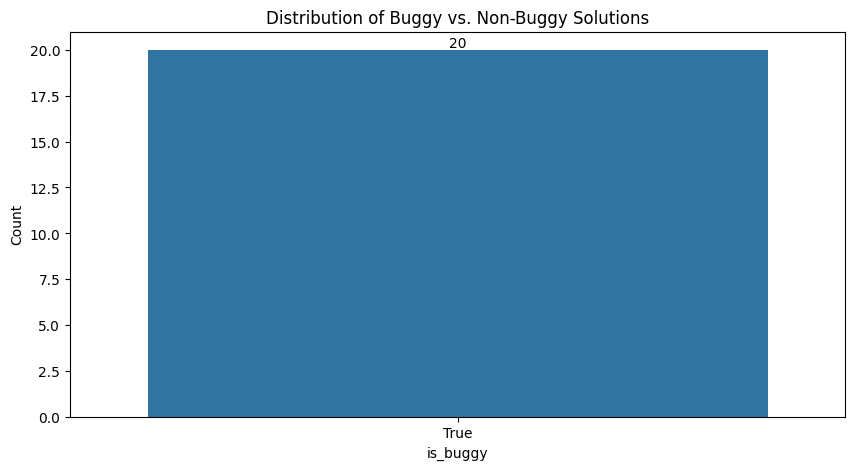

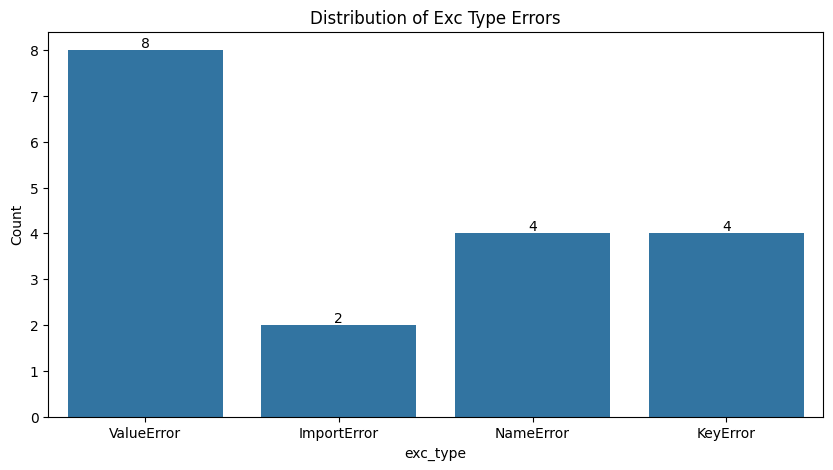

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Random Acts of Pizza Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/llama3.2/random-acts-of-pizza/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nfrom sklearn.ensemble imp...,I'm excited to help you with this problem. Her...,0,f4a072ccd865432aa911311fed123a97,1.733807e+09,None,[],<OMITTED>,0.882887,KeyError,{'args': ['request_text']},<OMITTED>,The code execution failed due to a KeyError re...,"{'value': None, 'maximize': None}",True
1,import pandas as pd\nfrom sklearn.model_select...,I'll provide a solution that uses a simple log...,1,ffca911eb2514c33bb2fadf5a2df0b1a,1.733807e+09,None,[],<OMITTED>,0.722849,ValueError,{'args': ['could not convert string to float: ...,<OMITTED>,The execution of the script failed due to a Va...,"{'value': None, 'maximize': None}",True
2,import pandas as pd\nfrom sklearn.model_select...,I'll provide a solution that uses a simple log...,2,bdeae74600144b92be00f152ed31f7e6,1.733807e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.681576,ValueError,{'args': ['could not convert string to float: ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The code execution failed due to a ValueError ...,"{'value': None, 'maximize': None}",True
3,import pandas as pd\nfrom sklearn.model_select...,I'm excited to take on this challenge. Based o...,3,139d70d33e7d480ba8123cb0c0a3e516,1.733807e+09,None,[],<OMITTED>,0.611859,ValueError,{'args': ['could not convert string to float: ...,<OMITTED>,"The execution failed due to a ValueError, indi...","{'value': None, 'maximize': None}",True
4,import pandas as pd\nfrom sklearn.model_select...,"Based on the provided task description, I will...",4,7b2ec15ff73c4f2d9ad1f185ab5844f1,1.733807e+09,None,[],"[Traceback (most recent call last):\n File ""r...",0.640793,ValueError,{'args': ['could not convert string to float: ...,[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution of the script failed due to a Va...,"{'value': None, 'maximize': None}",True


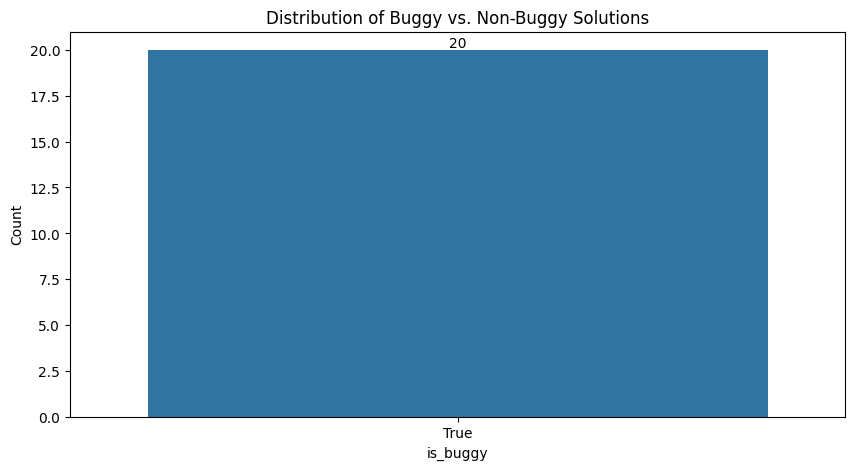

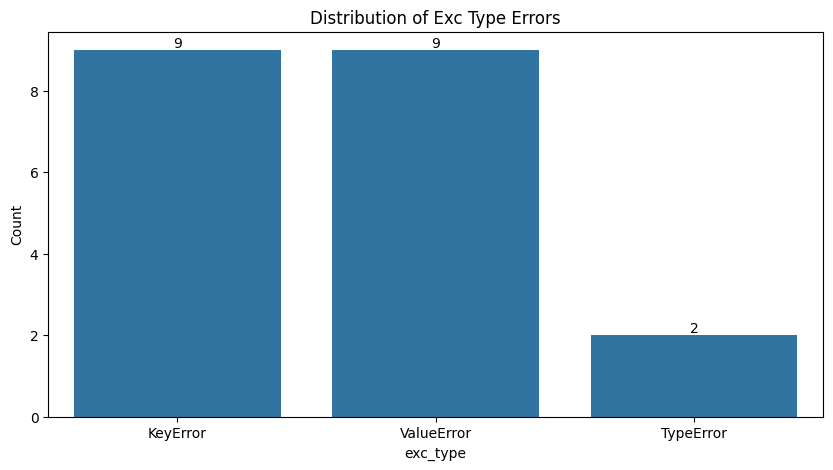

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

#### Text Normalization Challenge English Language Competition

In [ ]:
# Load the journal file
journal = read_json_file("/content/AideRL/llama3.2/text-normalization-challenge-english-language/logs/journal.json")
# Convert JSON data to DataFrame
df = pd.DataFrame(journal["nodes"])
df.head()

,code,plan,step,id,ctime,parent,children,_term_out,exec_time,exc_type,exc_info,exc_stack,analysis,metric,is_buggy
0,import pandas as pd\nimport torch\nimport torc...,"Based on the task description, I will propose ...",0,ff0fba1d1bf5445b904ae72cd2ce24ff,1.733808e+09,None,[],<OMITTED>,7.715131,NameError,"{'args': ['name 'Tokenizer' is not defined'], ...",<OMITTED>,The execution failed due to a NameError: the '...,"{'value': None, 'maximize': None}",True
1,import pandas as pd\nimport torch\nfrom transf...,I'm excited to take on the Text Normalization ...,1,4a8596cb0d4441faaefec5585603fb53,1.733808e+09,None,[],"[Traceback (most recent call last):\n File ""r...",8.674761,FileNotFoundError,"{'args': ['2', 'No such file or directory']}",[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The execution failed due to a FileNotFoundErro...,"{'value': None, 'maximize': None}",True
2,import pandas as pd\nimport torch\nfrom transf...,"Based on the provided details, I'll outline a ...",2,fc4844752e9e4c8a93d4113dbef657bd,1.733808e+09,None,[],"[Traceback (most recent call last):\n File ""r...",8.737121,FileNotFoundError,"{'args': ['2', 'No such file or directory']}",[[/opt/conda/envs/agent/lib/python3.11/site-pa...,The code execution failed due to a FileNotFoun...,"{'value': None, 'maximize': None}",True
3,import pandas as pd\nimport numpy as np\nfrom ...,Here is a solution to the text normalization c...,3,048cb5fe8f5540a4a4f76dd7765d5300,1.733808e+09,None,[],<OMITTED>,7.018282,FileNotFoundError,"{'args': ['2', 'No such file or directory']}",<OMITTED>,The code execution failed due to a FileNotFoun...,"{'value': None, 'maximize': None}",True
4,import pandas as pd\nimport torch\nfrom transf...,I'm excited to take on the Text Normalization ...,4,9b1ab46ed7ed4940a2b0b9c1e8e7247f,1.733808e+09,None,[],<OMITTED>,1.947607,ModuleNotFoundError,{'args': ['No module named 'torch.utils.data.s...,<OMITTED>,The code execution failed due to a ModuleNotFo...,"{'value': None, 'maximize': None}",True


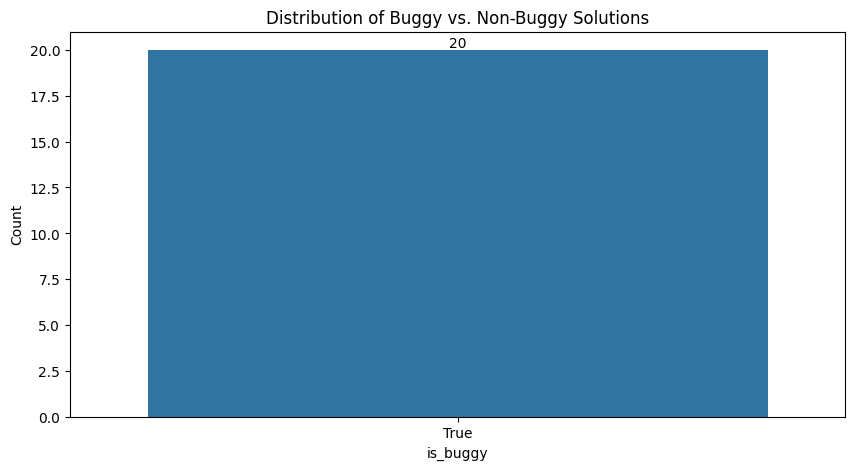

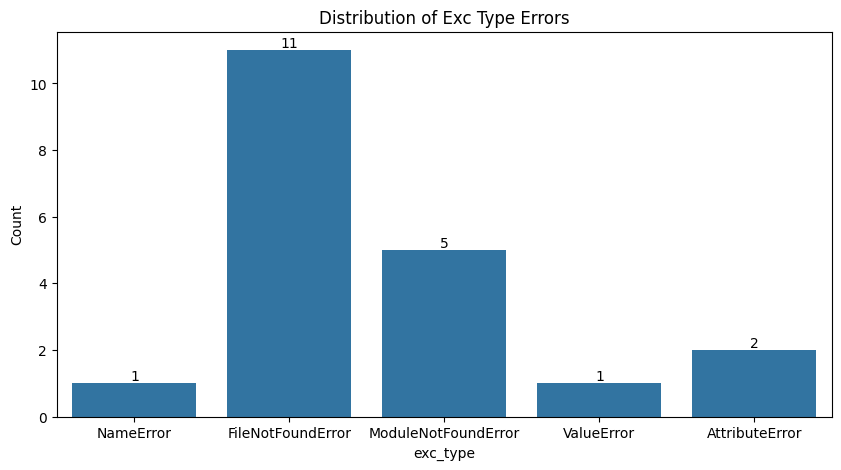

In [ ]:
# Visualize distribution of buggy vs. non-buggy challenges
visualize_barplot('is_buggy', df, 'Distribution of Buggy vs. Non-Buggy Solutions', 'is_buggy', 'Count')
print()
# Visualize distribution of exec error types for buggy solutions
visualize_barplot('exc_type', df, 'Distribution of Exc Type Errors', 'exc_type', 'Count')

### Student Model - Training Using Reinforcement Learning

#### Login to HuggingFace and Weights and Biases

In [ ]:
login()
wandb.login(key="0444d0091009eba5725ae52fd071f747971c78d7")

wandb: Currently logged in as: ar4422 (ar4422-columbia-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Load the journal data from the teacher and student models

In [ ]:
base_dir = '/content/AideRL'

# Load all the journal files for the teacher GPT-4o model
gpt_dir = os.path.join(base_dir, 'gpt')
competitions = [os.path.basename(x) for x in glob.glob(os.path.join(gpt_dir,'*'))]
gpt_journals = {}
for comp in competitions:
  gpt_journals[comp] = read_json_file(os.path.join(gpt_dir, comp, 'logs', 'journal.json'))

# Read the instructions (only stored in gpt directory)
instructions = {}
for comp in competitions:
  instructions[comp] = read_txt_file(os.path.join(gpt_dir, comp, 'logs', 'instructions.txt'))

# Load all the journal files for the student Llama 3.2 1b model
llama_dir = os.path.join(base_dir, 'llama3.2')
llama_competitions = [os.path.basename(x) for x in glob.glob(os.path.join(llama_dir,'*'))]
llama_journals = {}
for comp in llama_competitions:
  llama_journals[comp] = read_json_file(os.path.join(llama_dir, comp, 'logs', 'journal.json'))

for comp in llama_competitions:
  for node in llama_journals[comp]['nodes']:
    node["model_output"] =  node['plan'] + "\n" + "'''\n" + node['code'] + "'''" # convert journal back to original model output
  for node in gpt_journals[comp]['nodes']:
    node["model_output"] =  node['plan'] + "\n" + "'''\n" + node['code'] + "'''" # convert journal back to original model output

competitions

['google-quest-challenge',
 'random-acts-of-pizza',
 'nomad2018-predict-transparent-conductors',
 'spooky-author-identification',
 'text-normalization-challenge-english-language']

#### Create Preference-Style Dataset for Reward Model Training

In [ ]:
# Combine prompt, random non-buggy teacher model solution, 2 (or more ? )random buggy student model solutions for each competition
def create_preference_dataset(model1_nodes, model2_nodes):
    """
    Creates a preference dataset for RLHF from two journal files.

    Args:
        model1_nodes: These nodes will come from gpt model. We will combine gpt nodes within itself as well.
        model2_nodes: These nodes will come from llama.

    Returns:
        A list of dictionaries, where each dictionary represents a preference pair:
        {"chosen": <chosen_code>, "rejected": <rejected_code>}
    """

    preference_data = []

    # Pair nodes within the same model based on competition and step
    for i in range(len(model1_nodes) - 1):
      for j in range(i + 1, len(model1_nodes)):
        node1 = model1_nodes[i]
        node2 = model1_nodes[j]
        # Preference logic:
        if node1['is_buggy'] == False and node2['is_buggy'] == True:
          preference_data.append({"chosen": node1['model_output'], "rejected": node2['model_output']})
        elif node1['is_buggy'] == True and node2['is_buggy'] == False:
          preference_data.append({"chosen": node2['model_output'], "rejected": node1['model_output']})
        elif node1['is_buggy'] == False and node2['is_buggy'] == False:
          if node1['metric']['value'] < node2['metric']['value']:
            preference_data.append({"chosen": node1['model_output'], "rejected": node2['model_output']})
          else:
            preference_data.append({"chosen": node2['model_output'], "rejected": node1['model_output']})

    # Pair nodes across different models based on competition and step
    for node1 in model1_nodes:
      count = 0
      while count < 5: # combining with 5 random nodes from Llama nodes
        random_idx = random.randint(0, len(model2_nodes) - 1)
        node2 = model2_nodes[random_idx]
        # Preference logic:
        if node1['is_buggy'] == False and node2['is_buggy'] == True:
          preference_data.append({"chosen": node1['model_output'], "rejected": node2['model_output']})
          count+=1
        elif node1['is_buggy'] == True and node2['is_buggy'] == False:
          preference_data.append({"chosen": node2['model_output'], "rejected": node1['model_output']})
          count+=1
        elif node1['is_buggy'] == False and node2['is_buggy'] == False:
          if node1['metric']['value'] < node2['metric']['value']:
            preference_data.append({"chosen": node1['model_output'], "rejected": node2['model_output']})
            count+=1
          else:
            preference_data.append({"chosen": node2['model_output'], "rejected": node1['model_output']})
            count+=1
        else:
          break

    return preference_data

In [ ]:
preference_data = {}
for comp in competitions:
  preference_data[comp] = create_preference_dataset(gpt_journals[comp]['nodes'], llama_journals[comp]['nodes'])
  for data in preference_data[comp]:
    data['prompt'] = instructions[comp]

In [ ]:
data = []
for comp in preference_data:
  data.extend(preference_data[comp])

# Convert the list of dictionaries to a Hugging Face Dataset
dataset = Dataset.from_list(data)
dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 893
})

In [ ]:
# Load the pre-trained language model
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
reward_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, trust_remote_code=True, num_labels=1
)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def prepare_dataset(dataset, tokenizer):
    """pre-tokenize the dataset before training; only collate during training"""

    def tokenize(element):
        # Tokenize chosen and rejected sequences separately
        chosen_outputs = tokenizer(
            element["prompt"],
            element["chosen"],
            padding=False,
            truncation=True,  # Add truncation
            max_length=5020
        )
        rejected_outputs = tokenizer(
            element["prompt"],
            element["rejected"],
            padding=False,
            truncation=True,  # Add truncation
            max_length=5020
        )

        # Return the expected keys
        return {
            "input_ids_chosen": chosen_outputs["input_ids"],
            "attention_mask_chosen": chosen_outputs["attention_mask"],
            "input_ids_rejected": rejected_outputs["input_ids"],
            "attention_mask_rejected": rejected_outputs["attention_mask"],
        }

    return dataset.map(
        tokenize,
        batched=True,
        batch_size=1,
        remove_columns=dataset.column_names,
    )

In [ ]:
dataset = prepare_dataset(dataset, tokenizer)

Map:   0%|          | 0/893 [00:00<?, ? examples/s]

In [ ]:
# Explicitly create train and eval datasets using slices
eval_dataset = dataset.select(range(100))  # Take first 100 samples for evaluation
train_dataset = dataset.select(range(100, len(dataset)))  # Take the rest for training
print(f"train_dataset: {train_dataset}")
print(f"eval_dataset: {eval_dataset}")

#### Train the Reward Model

In [ ]:
# 3. Create a RewardTrainer instance
# Define your reward configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

training_args = RewardConfig(
    output_dir="/content/reward_model_output",  # Directory to save the model
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,  # Adjust as needed
    learning_rate=1e-5,   # Adjust as needed
    center_rewards_coefficient=0.01,
    remove_unused_columns=False,
    logging_steps=500,
)

trainer = RewardTrainer(
    model=reward_model,
    args=training_args,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
)

In [ ]:
# Train the reward model
trainer.train()

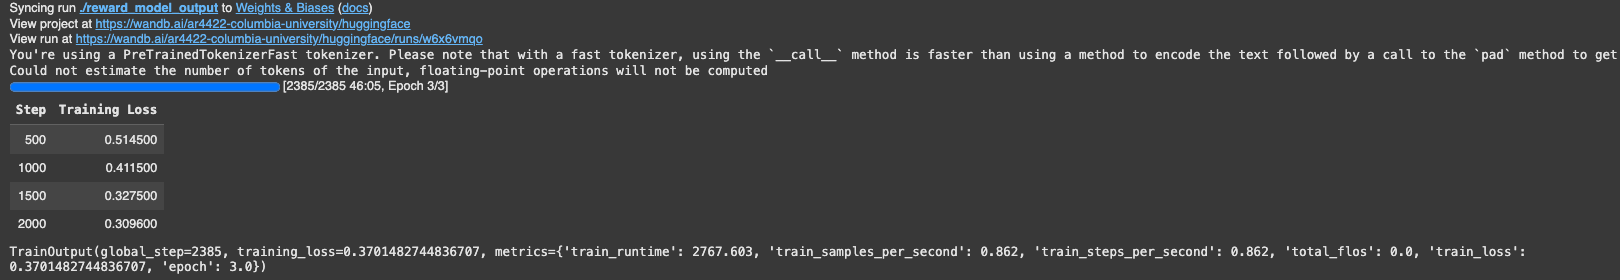

In [ ]:
# Save the trained reward model
trainer.save_model("/content/trained_reward_model_llama1B")

#### Prepare Prompts Dataset for Reinforcement Learning

In [ ]:
def extract_text(filename):
    """
    Extracts the text from the first '# Introduction' until the first 'INFO: response:' line.

    Args:
        filename: The name of the file to extract text from.

    Returns:
        A string containing the extracted text or None if the specified markers
        are not found.
    """

    with open(filename, 'r') as f:
        lines = f.readlines()

    start_marker = '# Introduction'
    end_marker = 'INFO: response:'
    extracted_text = []
    start_found = False

    for line in lines:
        if start_marker in line:
            start_found = True
            extracted_text.append(start_marker)
        elif end_marker in line and start_found:
            break
        elif start_found:
            extracted_text.append(line)

    if extracted_text:
        return ''.join(extracted_text)
    else:
        return None

In [ ]:
base_dir = '/content/AideRL/'

# Load all the journal files for the teacher GPT-4o model
run_dir = os.path.join(base_dir, 'get_prompt_run')
competitions = [os.path.basename(x) for x in glob.glob(os.path.join(run_dir,'*'))]
prompts = []
for comp in competitions:
  verbose_dir = os.path.join(run_dir, comp, 'logs', 'aide.verbose.log')
  extracted_content = extract_text(verbose_dir)
  if extracted_content:
    prompts.append({"prompt":extracted_content})
  else:
    print(f"The specified markers were not found in {verbose_dir}")

In [ ]:
prompts_dataset = Dataset.from_list(prompts)
prompts_dataset

Dataset({
    features: ['prompt'],
    num_rows: 44
})

In [ ]:
# Load the models needed for reinforcement learning
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
if tokenizer.chat_template is None:
    tokenizer.chat_template = SIMPLE_CHAT_TEMPLATE
model = AutoModelForCausalLM.from_pretrained(model_name)
ref_model = AutoModelForCausalLM.from_pretrained(model_name)
trained_reward_model = AutoModelForSequenceClassification.from_pretrained("/content/trained_reward_model_llama1B")

In [ ]:
################
# Dataset
################
eval_samples = 10
train_dataset = prompts_dataset.select(range(len(prompts_dataset) - eval_samples))
eval_dataset = prompts_dataset.select(range(len(prompts_dataset) - eval_samples, len(prompts_dataset)))
dataset_text_field = "prompt"

def prepare_dataset(dataset, tokenizer):
    """pre-tokenize the dataset before training; only collate during training"""

    def tokenize(element):
        outputs = tokenizer(
            element[dataset_text_field],
            padding=False,
            truncation=True,  # Add truncation
            max_length=2048,   # Limit sequence length (adjust as needed)
        )
        return {"input_ids": outputs["input_ids"]}

    return dataset.map(
        tokenize,
        batched=True,
        batch_size=1,
        remove_columns=dataset.column_names,
    )

# Compute that only on the main process for faster data processing.
# see: https://github.com/huggingface/trl/pull/1255
train_prompt_dataset = prepare_dataset(train_dataset, tokenizer)
eval_prompt_dataset = prepare_dataset(eval_dataset, tokenizer)

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

#### PPO Training

In [ ]:
################
# Training
################

ppo_config = {"mini_batch_size": 1, "batch_size": 1, "output_dir": 'content/'}
config = PPOConfig(**ppo_config)
trainer = PPOTrainer(
    config,
    tokenizer,
    policy=model,
    ref_policy=ref_model,
    reward_model=trained_reward_model,
    value_model=trained_reward_model,
    train_dataset=train_prompt_dataset,
    eval_dataset=eval_prompt_dataset,
)

In [ ]:
# Train Llama model with RL
trainer.train()

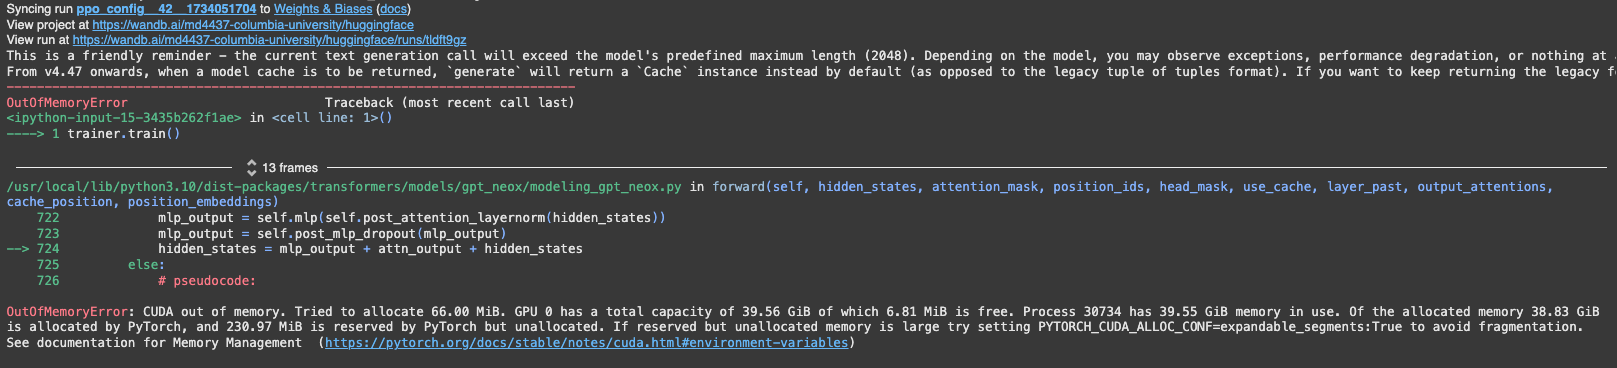

In [ ]:
# Save the trained Llama model
trainer.save_model("/content/trained_model_llama1B")